## Welcome to my EDA Kernel

### Description:
The dataset for this competition includes aggregate stopped vehicle information and intersection wait times. Your task is to predict congestion, based on an aggregate measure of stopping distance and waiting times, at intersections in 4 major US cities: Atlanta, Boston, Chicago & Philadelphia.

<img src="https://cdn.citylab.com/media/img/citylab/2018/02/AP_17153592466989/facebook.jpg" alt="Italian Trulli">


# Objective:
It's a first contact with the data, so I want to explore it and understand how the data is. 

Some important things that is standard to analyze:
- what are the data types of the features?
- We have missing values?
- How many unique values we have in each feature;
- The shape of full dataset.
- The entropy of each feature (that show us the level of disorder on this column, it's like a "messy metric")

After this first analyze we can think in other questions to explore:
- Which distribution we have in our columns? 
- Which are the most common cities?
- Which are the distribution of the stops, time, distances?
- How long is our date range? 
- What are the distribution of the regions?

And many more questions;

## <font color="red"> I'm near of grandmaster tier, so, if you find this kernel useful or interesting, please don't forget to upvote the kernel =)</font>

### Importing the Main Libraries to work with data

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import iplot, init_notebook_mode
#import cufflinks
#import cufflinks as cf
import plotly.figure_factory as ff

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression

from functools import partial
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/bigquery-geotab-intersection-congestion/train.csv
/kaggle/input/bigquery-geotab-intersection-congestion/sample_submission.csv
/kaggle/input/bigquery-geotab-intersection-congestion/test.csv
/kaggle/input/bigquery-geotab-intersection-congestion/submission_metric_map.json
/kaggle/input/bigquery-geotab-intersection-congestion/BigQuery-Dataset-Access.md


### Importing datasets

In [2]:
df_train = pd.read_csv('/kaggle/input/bigquery-geotab-intersection-congestion/train.csv')
df_test = pd.read_csv('/kaggle/input/bigquery-geotab-intersection-congestion/test.csv')

### Util functions 

In [3]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


### Summary of the data

In [4]:
resumetable(df_train)

Dataset Shape: (857409, 28)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,RowId,int64,0,857409,1920335,1920336,1920337,19.71
1,IntersectionId,int64,0,2539,0,0,0,10.63
2,Latitude,float64,0,4505,33.7917,33.7917,33.7917,11.41
3,Longitude,float64,0,4541,-84.43,-84.43,-84.43,11.43
4,EntryStreetName,object,8189,1707,Marietta Boulevard Northwest,Marietta Boulevard Northwest,Marietta Boulevard Northwest,8.97
5,ExitStreetName,object,5534,1693,Marietta Boulevard Northwest,Marietta Boulevard Northwest,Marietta Boulevard Northwest,8.95
6,EntryHeading,object,0,8,NW,SE,NW,2.85
7,ExitHeading,object,0,8,NW,SE,NW,2.85
8,Hour,int64,0,24,0,0,1,4.50
9,Weekend,int64,0,2,0,0,0,0.85


Nice, this func give us a lot of cool and useful informations;
- We have only two features with missing values. Entry and Exit StreetName

# City's
- I will start exploring the distribution of City's because it is a categorical with only a few categorys inside.


In [5]:
resumetable(df_train)

Dataset Shape: (857409, 28)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,RowId,int64,0,857409,1920335,1920336,1920337,19.71
1,IntersectionId,int64,0,2539,0,0,0,10.63
2,Latitude,float64,0,4505,33.7917,33.7917,33.7917,11.41
3,Longitude,float64,0,4541,-84.43,-84.43,-84.43,11.43
4,EntryStreetName,object,8189,1707,Marietta Boulevard Northwest,Marietta Boulevard Northwest,Marietta Boulevard Northwest,8.97
5,ExitStreetName,object,5534,1693,Marietta Boulevard Northwest,Marietta Boulevard Northwest,Marietta Boulevard Northwest,8.95
6,EntryHeading,object,0,8,NW,SE,NW,2.85
7,ExitHeading,object,0,8,NW,SE,NW,2.85
8,Hour,int64,0,24,0,0,1,4.50
9,Weekend,int64,0,2,0,0,0,0.85


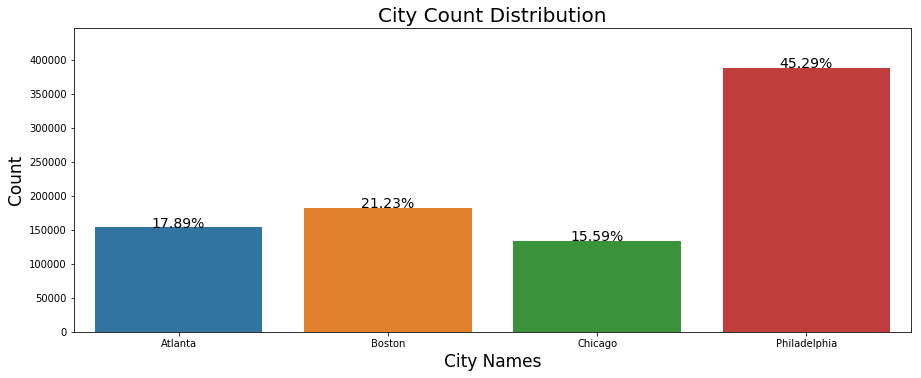

In [6]:
total = len(df_train)
plt.figure(figsize=(15,19))

plt.subplot(311)
g = sns.countplot(x="City", data=df_train)
g.set_title("City Count Distribution", fontsize=20)
g.set_ylabel("Count",fontsize= 17)
g.set_xlabel("City Names", fontsize=17)
sizes=[]
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 
g.set_ylim(0, max(sizes) * 1.15)

plt.show()

We can note that:
- The most common value is Philadelphia and it have 45.29% of the total entries.
- The other categories don't have a so discrepant difference between them. 
?
Let's 


# Date Features
- Hour Distribution
- Month Distribution


In [7]:
tmp_hour = df_train.groupby(['City', 'Hour'])['RowId'].nunique().reset_index()

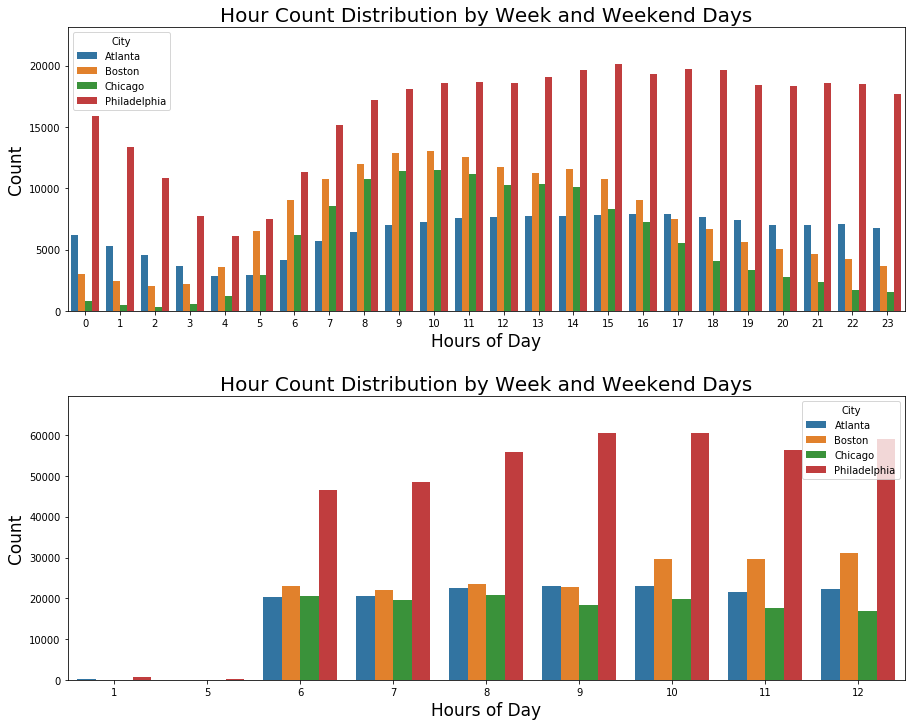

In [8]:
plt.figure(figsize=(15,12))

plt.subplot(211)
g = sns.countplot(x="Hour", data=df_train, hue='City', dodge=True)
g.set_title("Hour Count Distribution by Week and Weekend Days", fontsize=20)
g.set_ylabel("Count",fontsize= 17)
g.set_xlabel("Hours of Day", fontsize=17)
sizes=[]
for p in g.patches:
    height = p.get_height()
    sizes.append(height)

g.set_ylim(0, max(sizes) * 1.15)

plt.subplot(212)
g1 = sns.countplot(x="Month", data=df_train, hue='City', dodge=True)
g1.set_title("Hour Count Distribution by Week and Weekend Days", fontsize=20)
g1.set_ylabel("Count",fontsize= 17)
g1.set_xlabel("Hours of Day", fontsize=17)
sizes=[]
for p in g1.patches:
    height = p.get_height()
    sizes.append(height)

g1.set_ylim(0, max(sizes) * 1.15)

plt.subplots_adjust(hspace = 0.3)

plt.show()

Cool. <br>

In the hours chart:
- We can see that cities can have different hours patterns.
- Philadelphia is by far the most common in all hours. Only on 5 a.m that is almost lose to Boston in total entries.
- Atlanta is the city with less entries in all day, but after 17 p.m to 4a.m it's the second city with more rides 

In the month chart:
- We can note that the data is about only 6 months (with few values in January and May)
- Also, the pattern of the Boston City improved througout the time and the others seem very unchanged. 

Now, let's explore the Entry and Exit features.


# EntryHeading and Exit Heading

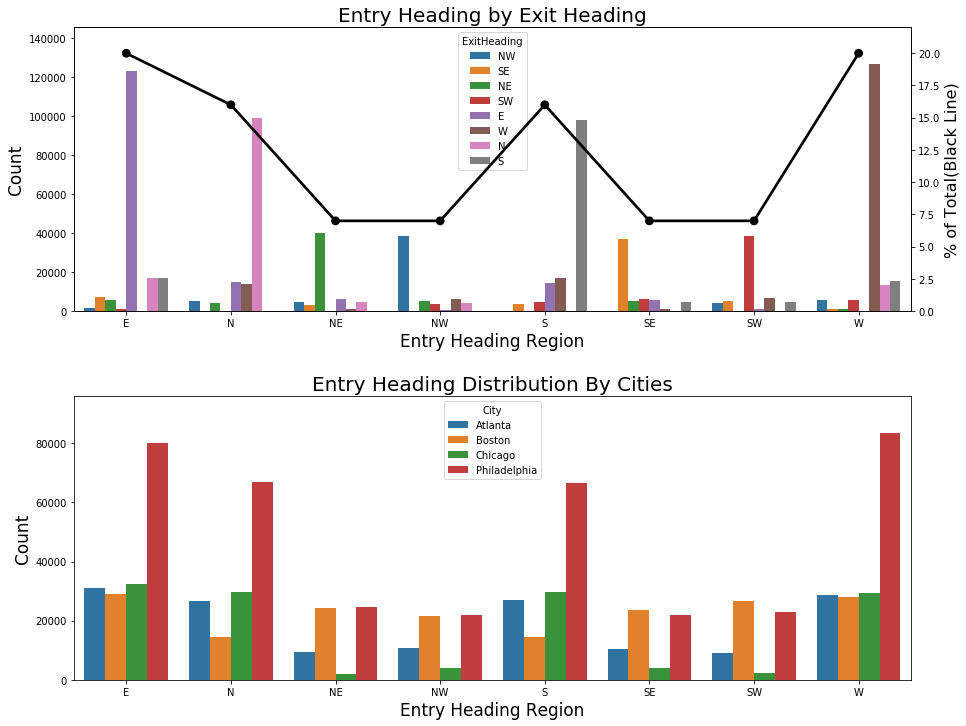

In [9]:
plt.figure(figsize=(15,12))

tmp = round(((df_train.groupby(['EntryHeading'])['RowId'].nunique() / total) * 100)).reset_index()

plt.subplot(211)
g = sns.countplot(x="EntryHeading",
                  data=df_train,
                  order=list(tmp['EntryHeading'].values),
                  hue='ExitHeading', dodge=True)
g.set_title("Entry Heading by Exit Heading", fontsize=20)
g.set_ylabel("Count",fontsize= 17)
g.set_xlabel("Entry Heading Region", fontsize=17)
gt = g.twinx()
gt = sns.pointplot(x='EntryHeading', y='RowId', 
                   data=tmp, order=list(tmp['EntryHeading'].values),
                   color='black', legend=False)
gt.set_ylim(0, tmp['RowId'].max()*1.1)
gt.set_ylabel("% of Total(Black Line)", fontsize=16)
sizes=[]
for p in g.patches:
    height = p.get_height()
    sizes.append(height)

g.set_ylim(0, max(sizes) * 1.15)

plt.subplot(212)
g1 = sns.countplot(x="EntryHeading", order=list(tmp['EntryHeading'].values), 
                   data=df_train, hue='City')
g1.set_title("Entry Heading Distribution By Cities", fontsize=20)
g1.set_ylabel("Count",fontsize= 17)
g1.set_xlabel("Entry Heading Region", fontsize=17)
sizes=[]
for p in g1.patches:
    height = p.get_height()
    sizes.append(height)

g1.set_ylim(0, max(sizes) * 1.15)

plt.subplots_adjust(hspace = 0.3)

plt.show()

Nice. <br>
In Entry and Exit Heading chart:
- We can note that in general the Entry and Exit Region is exactly the same. 

In Entry by Cities chart:
- We can note the difference patterns on the cities. It's a very interesting and could give us many interesting insights. 

## IntersectionID 

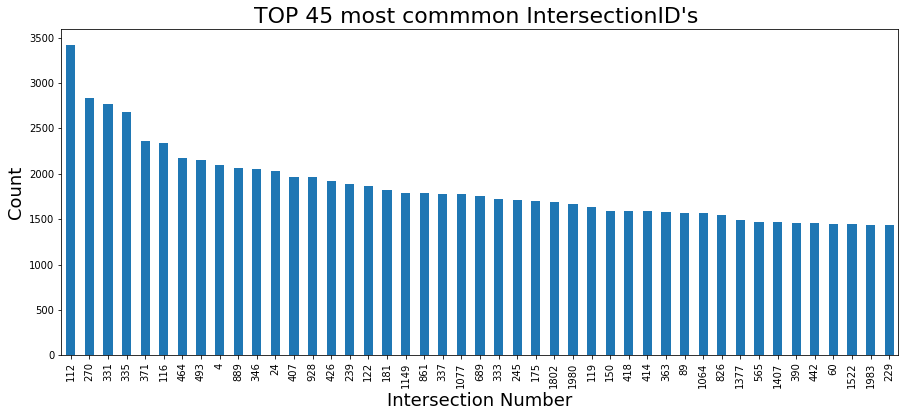

In [10]:
plt.figure(figsize=(15,6))
df_train.IntersectionId.value_counts()[:45].plot(kind='bar')
plt.xlabel("Intersection Number", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.title("TOP 45 most commmon IntersectionID's ", fontsize=22)

plt.show()

In [11]:
df_train.groupby(['IntersectionId', 'EntryHeading', 'ExitHeading'])['RowId'].count().reset_index().head()

,IntersectionId,EntryHeading,ExitHeading,RowId
0,0,E,E,150
1,0,E,N,24
2,0,N,E,31
3,0,N,N,59
4,0,N,W,22


# Exploring numerical features
If you readed the competition description, you know that these are the target features;

The targets are: 
- TotalTimeStopped_p20
- TotalTimeStopped_p50
- TotalTimeStopped_p80
- DistanceToFirstStop_p20
- DistanceToFirstStop_p50
- DistanceToFirstStop_p80

And the as the TimeFromFirstStop is an optional data, I will use it to see the correlations.


In [12]:
t_stopped = ['TotalTimeStopped_p20',
             'TotalTimeStopped_p50', 
             'TotalTimeStopped_p80']
t_first_stopped = ['TimeFromFirstStop_p20',
                   'TimeFromFirstStop_p50',
                   'TimeFromFirstStop_p80']
d_first_stopped = ['DistanceToFirstStop_p20',
                   'DistanceToFirstStop_p50',
                   'DistanceToFirstStop_p80']

# Heatmap Target Features

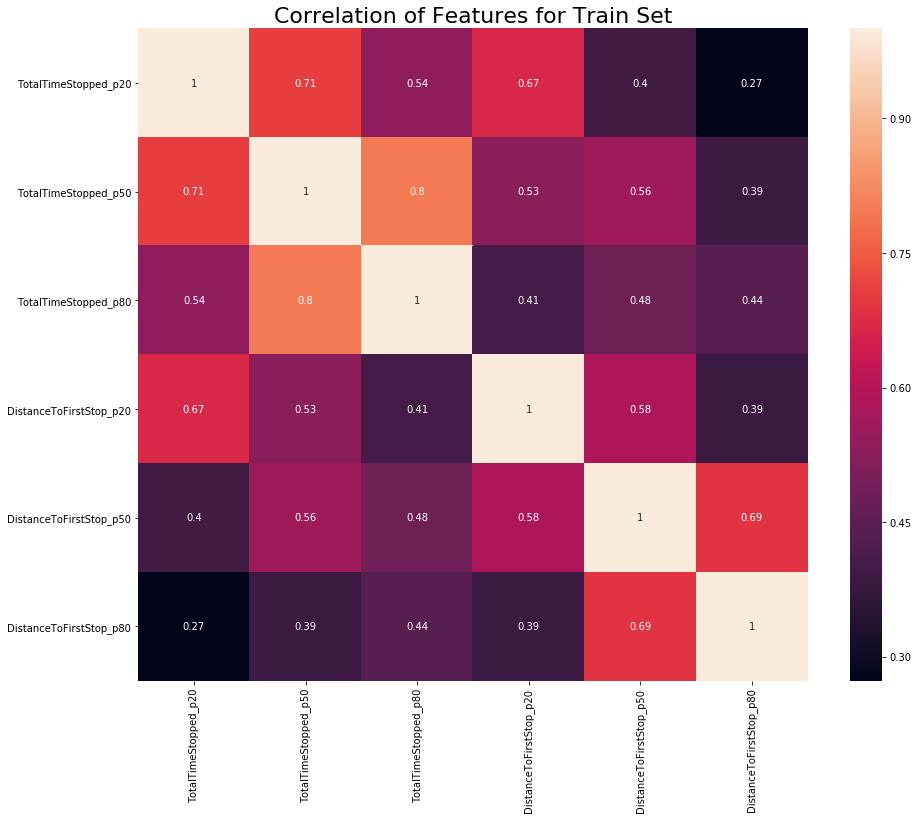

In [13]:
plt.figure(figsize=(15,12))
plt.title('Correlation of Features for Train Set', fontsize=22)
sns.heatmap(df_train[t_stopped + 
                     #t_first_stopped + 
                     d_first_stopped].astype(float).corr(),
            vmax=1.0,  annot=True)
plt.show()

Cool!<br>
We can see that the best correlation between the metrics are:
- Distance to First Stop p20 and Total Time Stopped p20 have a high correlation.

# Scaling the target
- Geting the min_max transformation to get clusterization and PCA features

In [14]:
from sklearn.preprocessing import minmax_scale

target_cols = t_stopped + d_first_stopped

In [15]:
for col in target_cols:
    df_train[col+str("_minmax")] = (minmax_scale(df_train[col], feature_range=(0,1)))
    
min_max_cols = ['TotalTimeStopped_p20_minmax', 'TotalTimeStopped_p50_minmax',
                'TotalTimeStopped_p80_minmax', 'DistanceToFirstStop_p20_minmax',
                'DistanceToFirstStop_p50_minmax', 'DistanceToFirstStop_p80_minmax']

# PCA
- To better see the distribution of our metrics, lets apply PCA to reduce the dimensionality of the data

In [16]:
pca = PCA(n_components=3, random_state=5)

principalComponents = pca.fit_transform(df_train[min_max_cols])

principalDf = pd.DataFrame(principalComponents)

# df.drop(cols, axis=1, inplace=True)
prefix='Target_PCA'
principalDf.rename(columns=lambda x: str(prefix)+str(x), inplace=True)

df_train = pd.concat([df_train, principalDf], axis=1)

Nice, now we have the PCA features... Let's see the ratio of explanation of the first two Principal Components

In [17]:
pca.explained_variance_ratio_[:2].sum()

0.8393328815798986

With the 2 first components we have almost 84% of the data explained. It's a very way to easiest visualize the differences between the patterns.

# Scatter plot of cities by the PCA 

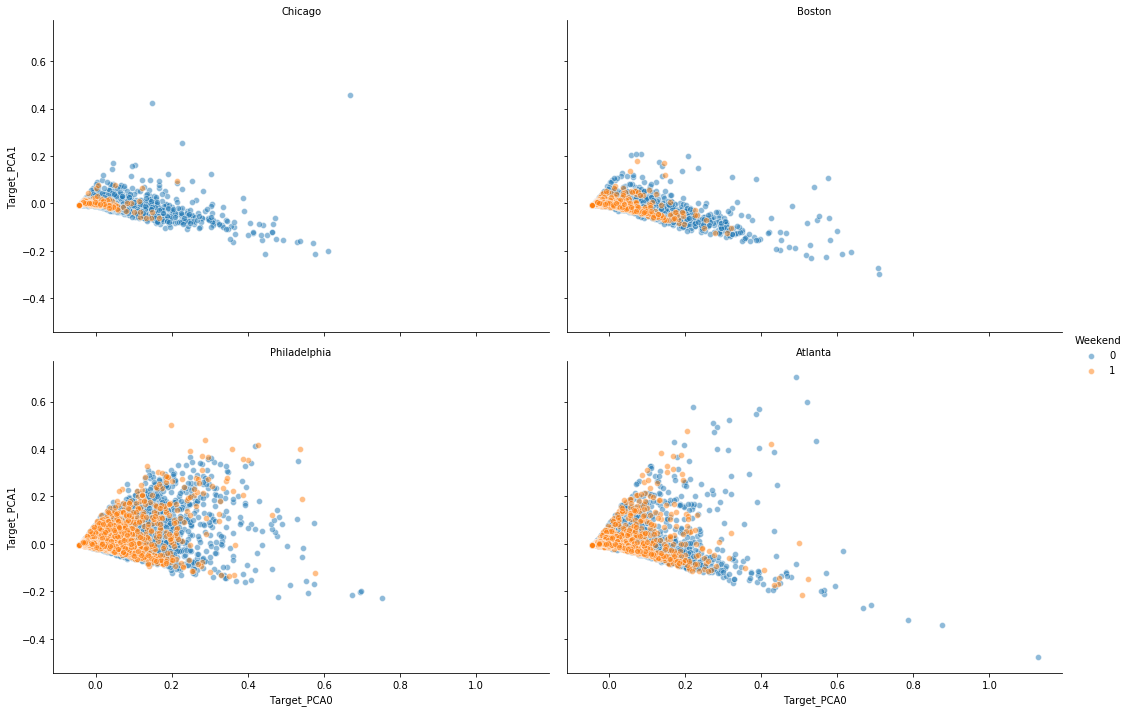

In [18]:
g = sns.FacetGrid(df_train.sample(50000), col="City", 
                  col_wrap=2, height=5, aspect=1.5, hue='Weekend')

g.map(sns.scatterplot, "Target_PCA0", "Target_PCA1", alpha=.5 ).add_legend();
g.set_titles('{col_name}', fontsize=17)
plt.show()

Cool. We can see differet patterns by the Cities and their weekend patterns. 

# KMeans Clusterization
- First, I will apply the elbow method to find the correct number of cluster we have in our data
- After it, we will implement the kmeans with the best quantity

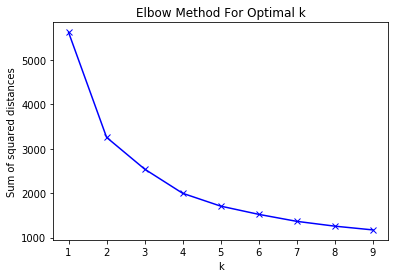

In [19]:
#sum of squared distances
ssd = []

K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k, random_state=4)
    km = km.fit(df_train[min_max_cols])
    ssd.append(km.inertia_)
    
plt.plot(K, ssd, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')

plt.show()

Nice. <br>
Based on Elbow Method the best number of cluster is 4. So, let's apply the K means on data.

In [20]:
km = KMeans(n_clusters=4, random_state=4)
km = km.fit(df_train[min_max_cols])
df_train['clusters_T'] = km.predict(df_train[min_max_cols])

## Ploting Clusters
- Understanding the cluster distribution
- Exploring by Cities

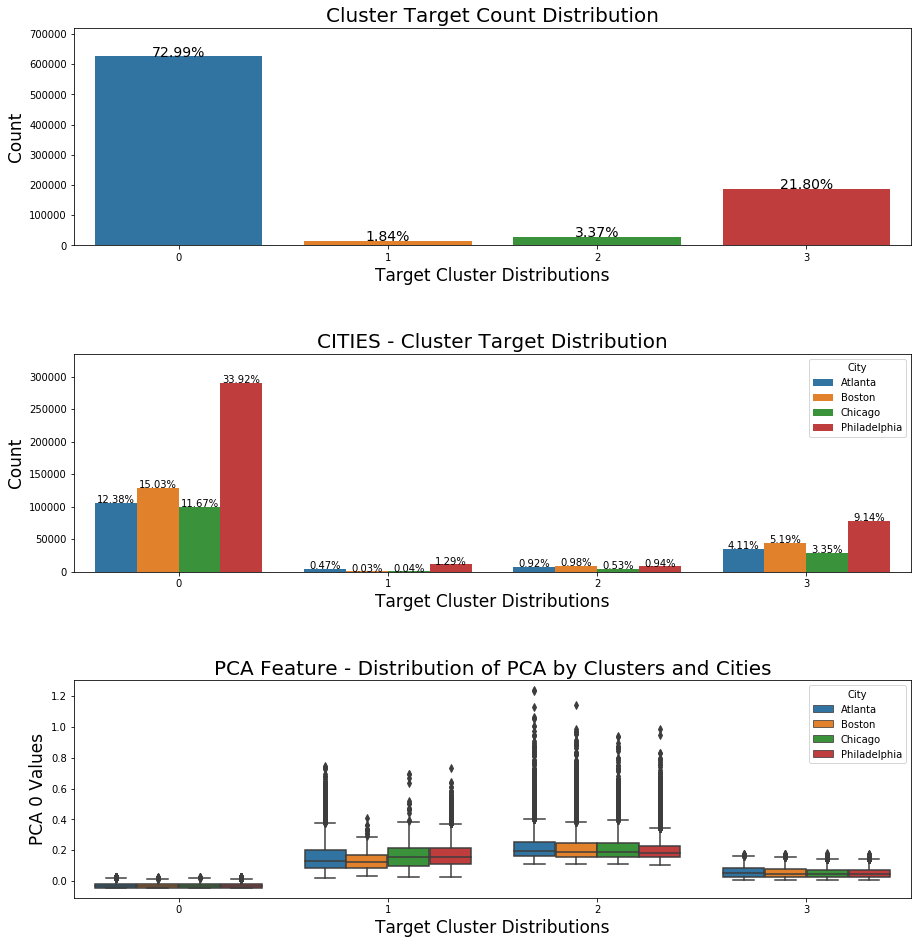

In [21]:
tmp = pd.crosstab(df_train['City'], df_train['clusters_T'], 
                  normalize='columns').unstack('City').reset_index().rename(columns={0:"perc"})

total = len(df_train)
plt.figure(figsize=(15,16))

plt.subplot(311)
g = sns.countplot(x="clusters_T", data=df_train)
g.set_title("Cluster Target Count Distribution", fontsize=20)
g.set_ylabel("Count",fontsize= 17)
g.set_xlabel("Target Cluster Distributions", fontsize=17)
sizes=[]
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 
g.set_ylim(0, max(sizes) * 1.15)

plt.subplot(312)
g1 = sns.countplot(x="clusters_T", data=df_train, hue='City')
g1.set_title("CITIES - Cluster Target Distribution", fontsize=20)
g1.set_ylabel("Count",fontsize= 17)
g1.set_xlabel("Target Cluster Distributions", fontsize=17)
sizes=[]
for p in g1.patches:
    height = p.get_height()
    sizes.append(height)
    g1.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=10)
g1.set_ylim(0, max(sizes) * 1.15)

plt.subplot(313)
g1 = sns.boxplot(x="clusters_T", y='Target_PCA0', 
                 data=df_train, hue='City')
g1.set_title("PCA Feature - Distribution of PCA by Clusters and Cities", 
             fontsize=20)
g1.set_ylabel("PCA 0 Values",fontsize= 17)
g1.set_xlabel("Target Cluster Distributions", fontsize=17)

plt.subplots_adjust(hspace = 0.5)

plt.show()

Nice. <br>
### In the first chart:
- We can note that the most common cluster is the 1 that have 73% of all data.

### Second chart: 
- Philadelphia is the most common in the first 3 clusters. 
- Boston is the second most common in 0,1 and the most common on Cluster 3;
- In the second cluster, Atlanta is the second most common city.

### Third Chart:
- Is clear to understand how the algorithmn divided the data in PCA values

## NOTE: EVERY TIME I RUN IT, THE VALUES CHANGES, SO SORRY BY THE WRONG 


# PCA values by CLUSTERS 
- Let's see in another way how the algorithmn have decided by the clusterization

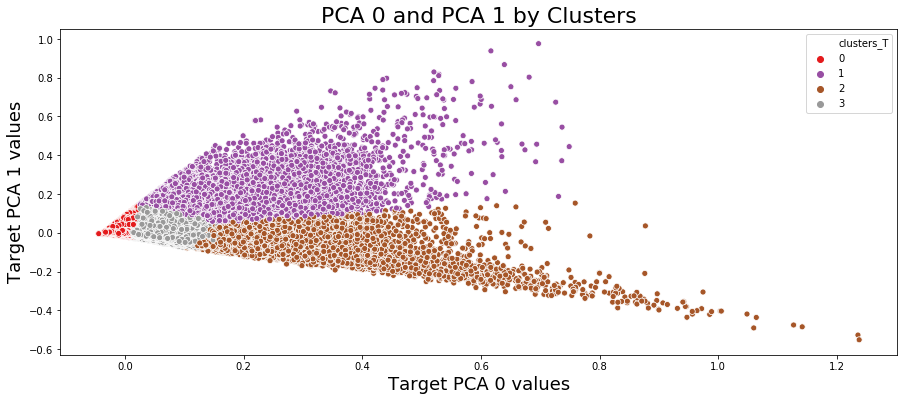

In [22]:
plt.figure(figsize=(15,6))

sns.scatterplot(x='Target_PCA0', y='Target_PCA1',
                hue='clusters_T', data=df_train,
                palette='Set1')
plt.title("PCA 0 and PCA 1 by Clusters", fontsize=22)
plt.ylabel("Target PCA 1 values", fontsize=18)
plt.xlabel("Target PCA 0 values", fontsize=18)

plt.show()

Cool. It gives us a good understand of the boundaries of Clusters. <br>
I suspect that the cluster 2 is about traffic;

Let's plot it by each city and try to find any pattern in the PCA dispersion.

# PCA Dispersion by clusters and by Each City
- To better understand the patterns, let's plot by Cities

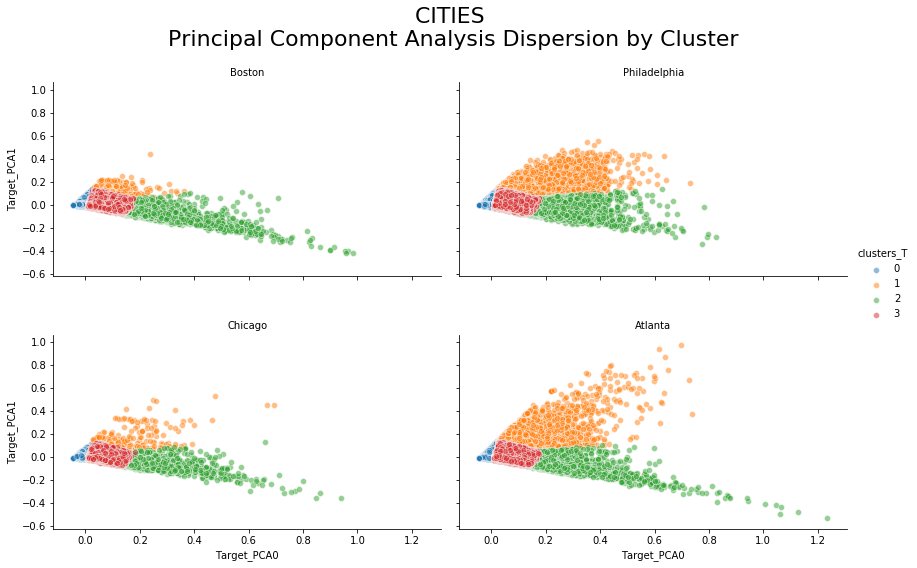

In [23]:
g = sns.FacetGrid(df_train.sample(500000), col="City", 
                  col_wrap=2, height=4, aspect=1.5, 
                  hue='clusters_T')

g.map(sns.scatterplot, "Target_PCA0", "Target_PCA1", 
      alpha=.5).add_legend();
g.set_titles('{col_name}', fontsize=50)

plt.suptitle("CITIES \nPrincipal Component Analysis Dispersion by Cluster", fontsize=22)

plt.subplots_adjust(hspace = 0.3, top=.85)

plt.show()

Cool! We can see that Atlanta and Philadelphia have similar pattern of the Cluster 2;<Br>
The other cluster seens very similar 

# Clusters by the Hours
I was wondering and I had an insight that I will try to implement here. 
- I think that make a lot of sense explore the hours by the clusters
- Let's see the distribution of PCA0 and the Clusters by the Hours

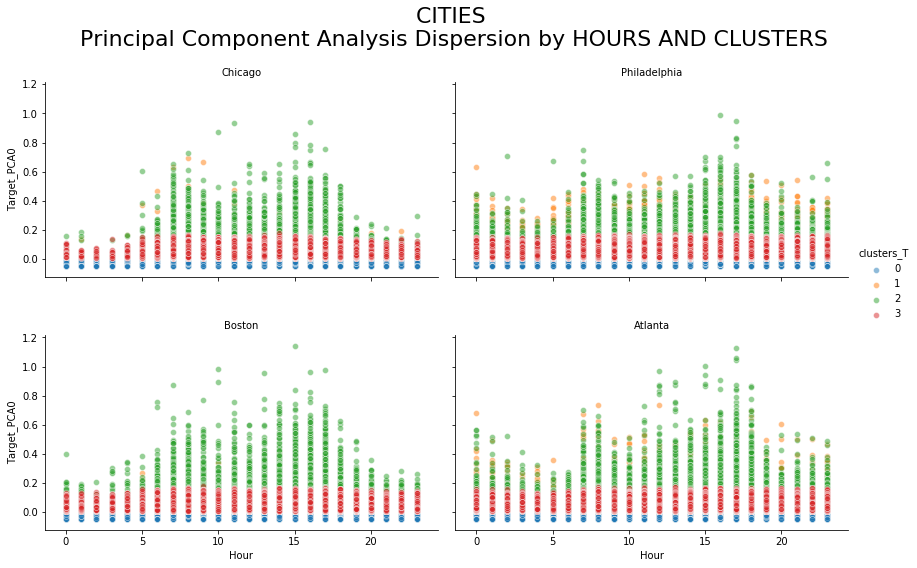

In [24]:
g = sns.FacetGrid(df_train.sample(500000), col="City", 
                  col_wrap=2, height=4, aspect=1.5, 
                  hue='clusters_T')

g.map(sns.scatterplot, "Hour", "Target_PCA0", 
      alpha=.5).add_legend();
g.set_titles('{col_name}', fontsize=50)

plt.suptitle("CITIES \nPrincipal Component Analysis Dispersion by HOURS AND CLUSTERS", fontsize=22)

plt.subplots_adjust(hspace = 0.3, top=.85)

plt.show()

Cool! We can have a best intuition about the data and how it posible clustered the data. 

In [25]:
round(pd.crosstab([df_train['clusters_T'], df_train['Weekend']], df_train['City'],
            normalize='index' ) * 100,0)

City                Atlanta  Boston  Chicago  Philadelphia
clusters_T Weekend                                        
0          0           15.0    22.0     22.0          41.0
           1           22.0    16.0      3.0          59.0
1          0           24.0     2.0      3.0          71.0
           1           30.0     1.0      0.0          69.0
2          0           24.0    32.0     18.0          26.0
           1           43.0    15.0      2.0          41.0
3          0           17.0    26.0     19.0          38.0
           1           27.0    14.0      2.0          56.0

# Modeling 
- As I was getting problems with my model, I decided to implement the solution of the public kernels
- I will import the datasets again 

Many parts of this implementation I got on @dcaichara Kernel. <br>
You can see the kernel here: https://www.kaggle.com/dcaichara/feature-engineering-and-lightgbm

In [26]:
df_train = pd.read_csv('/kaggle/input/bigquery-geotab-intersection-congestion/train.csv')
df_test = pd.read_csv('/kaggle/input/bigquery-geotab-intersection-congestion/test.csv')

## Hour Feature 
- Let's encode the Hour Features

In [27]:
def date_cyc_enc(df, col, max_vals):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col]/max_vals)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col]/max_vals)
    return df

df_train = date_cyc_enc(df_train, 'Hour', 24)
df_test = date_cyc_enc(df_test, 'Hour', 24) 

## Flag - is day?
Testing some features about the data

In [28]:
df_train['is_day'] = df_train['Hour'].apply(lambda x: 1 if 7 < x < 18 else 0)
df_test['is_day'] = df_test['Hour'].apply(lambda x: 1 if 7 < x < 18 else 0)

df_train['is_morning'] = df_train['Hour'].apply(lambda x: 1 if 6 < x < 10 else 0)
df_test['is_morning'] = df_test['Hour'].apply(lambda x: 1 if 6 < x < 10 else 0)

df_train['is_night'] = df_train['Hour'].apply(lambda x: 1 if 17 < x < 20 else 0)
df_test['is_night'] = df_test['Hour'].apply(lambda x: 1 if 17 < x < 20 else 0)

df_train['is_day_weekend'] = np.where((df_train['is_day'] == 1) & (df_train['Weekend'] == 1), 1,0)
df_test['is_day_weekend'] = np.where((df_test['is_day'] == 1) & (df_train['Weekend'] == 1), 1,0)

df_train['is_mor_weekend'] = np.where((df_train['is_morning'] == 1) & (df_train['Weekend'] == 1), 1,0)
df_test['is_mor_weekend'] = np.where((df_test['is_morning'] == 1) & (df_train['Weekend'] == 1), 1,0)

df_train['is_nig_weekend'] = np.where((df_train['is_night'] == 1) & (df_train['Weekend'] == 1), 1,0)
df_test['is_nig_weekend'] = np.where((df_test['is_night'] == 1) & (df_train['Weekend'] == 1), 1,0)

# Intersec - Concatenating IntersectionId and City

In [29]:
df_train["Intersec"] = df_train["IntersectionId"].astype(str) + df_train["City"]
df_test["Intersec"] = df_test["IntersectionId"].astype(str) + df_test["City"]

print(df_train["Intersec"].sample(6).values)

['7Boston' '598Philadelphia' '1525Philadelphia' '1823Chicago'
 '1786Philadelphia' '175Atlanta']


# Label Encoder of Intersecion + City

In [30]:
le = LabelEncoder()

le.fit(pd.concat([df_train["Intersec"],df_test["Intersec"]]).drop_duplicates().values)
df_train["Intersec"] = le.transform(df_train["Intersec"])
df_test["Intersec"] = le.transform(df_test["Intersec"])

# Street Feature
- Extracting informations from street features

In [31]:
road_encoding = {
    'Road': 1,
    'Street': 2,
    'Avenue': 2,
    'Drive': 3,
    'Broad': 3,
    'Boulevard': 4
}

In [32]:
def encode(x):
    if pd.isna(x):
        return 0
    for road in road_encoding.keys():
        if road in x:
            return road_encoding[road]
    return 0

## Creating the new feature

In [33]:
df_train['EntryType'] = df_train['EntryStreetName'].apply(encode)
df_train['ExitType'] = df_train['ExitStreetName'].apply(encode)
df_test['EntryType'] = df_test['EntryStreetName'].apply(encode)
df_test['ExitType'] = df_test['ExitStreetName'].apply(encode)

# Encoding the Regions

In [34]:
directions = {
    'N': 0,
    'NE': 1/4,
    'E': 1/2,
    'SE': 3/4,
    'S': 1,
    'SW': 5/4,
    'W': 3/2,
    'NW': 7/4
}

## Applying the transformation in Entry and Exit Heading Columns

In [35]:
df_train['EntryHeading'] = df_train['EntryHeading'].map(directions)
df_train['ExitHeading'] = df_train['ExitHeading'].map(directions)

df_test['EntryHeading'] = df_test['EntryHeading'].map(directions)
df_test['ExitHeading'] = df_test['ExitHeading'].map(directions)

# Difference between the regions

In [36]:
df_train['diffHeading'] = df_train['EntryHeading']-df_train['ExitHeading']  
df_test['diffHeading'] = df_test['EntryHeading']-df_test['ExitHeading'] 

## Getting the binary if the entry and exit was in the same street

In [37]:
df_train["same_str"] = (df_train["EntryStreetName"] ==  df_train["ExitStreetName"]).astype(int)
df_test["same_str"] = (df_test["EntryStreetName"] ==  df_test["ExitStreetName"]).astype(int)

## Concatenating City and Month

In [38]:
# Concatenating the city and month into one variable
df_train['city_month'] = df_train["City"] + df_train["Month"].astype(str)
df_test['city_month'] = df_test["City"] + df_test["Month"].astype(str)

## Month rainfall ratio by city and seasons

In [39]:
monthly_rainfall = {'Atlanta1': 5.02, 'Atlanta5': 3.95, 'Atlanta6': 3.63, 'Atlanta7': 5.12, 
                    'Atlanta8': 3.67, 'Atlanta9': 4.09,'Atlanta10': 3.11, 'Atlanta11': 4.10, 
                    'Atlanta12': 3.82, 'Boston1': 3.92, 'Boston5': 3.24, 'Boston6': 3.22,
                    'Boston7': 3.06, 'Boston8': 3.37, 'Boston9': 3.47, 'Boston10': 3.79,
                    'Boston11': 3.98, 'Boston12': 3.73, 'Chicago1': 1.75, 'Chicago5': 3.38,
                    'Chicago6': 3.63, 'Chicago7': 3.51, 'Chicago8': 4.62, 'Chicago9': 3.27,
                    'Chicago10': 2.71,  'Chicago11': 3.01, 'Chicago12': 2.43, 
                    'Philadelphia1': 3.52, 'Philadelphia5': 3.88, 'Philadelphia6': 3.29,
                    'Philadelphia7': 4.39, 'Philadelphia8': 3.82, 'Philadelphia9':3.88 ,
                    'Philadelphia10': 2.75, 'Philadelphia11': 3.16, 'Philadelphia12': 3.31}

# Creating a new column by mapping the city_month variable to it's corresponding average monthly rainfall
df_train["average_rainfall"] = df_train['city_month'].map(monthly_rainfall)
df_test["average_rainfall"] = df_test['city_month'].map(monthly_rainfall)

# Getting Dummies 

In [40]:
print(f'Shape before dummy transformation: {df_train.shape}')
df_train = pd.get_dummies(df_train, columns=['City' ],\
                          prefix=['City'], drop_first=False)

print(f'Shape after dummy transformation: {df_train.shape}')

df_test = pd.get_dummies(df_test, columns=['City' ],\
                          prefix=['City'], drop_first=False)


Shape before dummy transformation: (857409, 43)
Shape after dummy transformation: (857409, 46)


# MinMax Scaling the lat and long

In [41]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
for col in ['Latitude','Longitude']:
    scaler.fit(df_train[col].values.reshape(-1, 1))
    df_train[col] = scaler.transform(df_train[col].values.reshape(-1, 1))
    df_test[col] = scaler.transform(df_test[col].values.reshape(-1, 1))

## Dropping not used features

In [42]:
df_train.drop(['RowId', 'Path','EntryStreetName','ExitStreetName'
              ],axis=1, inplace=True)
df_test.drop(['RowId', 'Path',
              'EntryStreetName','ExitStreetName'],axis=1, inplace=True)

In [43]:
interesting_feat = ['IntersectionId', 'Latitude', 'Longitude', 'EntryHeading',
                    'ExitHeading', 'Hour', 'Weekend', 'Month',
                    'is_morning', 'is_night', 'is_day_weekend', 'is_mor_weekend',
                    'is_nig_weekend', #  'Hour_sin',
                    'Hour', 'same_str', 'Intersec', 'EntryType',
                    'ExitType', 'diffHeading', 'average_rainfall', 'is_day',
                    'City_Boston', 'City_Chicago', 'City_Philadelphia', 
                    'City_Atlanta']

total_time = ['TotalTimeStopped_p20',
              'TotalTimeStopped_p50', 
              'TotalTimeStopped_p80']

target_stopped = ['DistanceToFirstStop_p20',
                  'DistanceToFirstStop_p50',
                  'DistanceToFirstStop_p80']


## Setting X and y

In [44]:
X = df_train[interesting_feat]
y = df_train[total_time + target_stopped]

X_test = df_test[interesting_feat]

In [45]:
print(f'Shape of X: {X.shape}')
print(f'Shape of X_test: {X_test.shape}')

Shape of X: (857409, 25)
Shape of X_test: (1920335, 25)


## Reduce memory usage

X = reduce_mem_usage(X)
X_test = reduce_mem_usage(X_test)

## Spliting data into train and validation

In [46]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10,
                                                  random_state=42)

# Hyperopt Space
- Here we will set all range of our hyperparameters


In [47]:
# Define searched space
hyper_space = {'objective': 'regression',
               'metric':'rmse',
               'boosting':'gbdt', 'gpu_device_id': 0,
               #'n_estimators': hp.choice('n_estimators', [25, 40, 50, 75, 100, 250, 500]),
               'max_depth':  hp.choice('max_depth', list(range(6, 18, 2))),
               'num_leaves': hp.choice('num_leaves', list(range(20, 180, 20))),
               'subsample': hp.choice('subsample', [.7, .8, .9, 1]),
               'colsample_bytree': hp.uniform('colsample_bytree', 0.7, 1),
               'learning_rate': hp.uniform('learning_rate', 0.03, 0.12),
               #'reg_alpha': hp.choice('reg_alpha', [.1, .2, .3, .4, .5, .6]),
               #'reg_lambda':  hp.choice('reg_lambda', [.1, .2, .3, .4, .5, .6]),               
               'min_child_samples': hp.choice('min_child_samples', [20, 45, 70, 100])}

## Building Hyperopt Function to be optimized

In [48]:
cat_feat = ['IntersectionId','Hour', 'Weekend','Month', 
            'is_day', 'is_morning', 'is_night', 
            'same_str', 'Intersec', 'City_Atlanta', 'City_Boston',
            'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType']

In [49]:
from sklearn.model_selection import KFold
import lightgbm as lgb

def evaluate_metric(params):
    
    all_preds_test ={0:[],1:[],2:[],3:[],4:[],5:[]}
    
    print(f'Params: {params}')
    FOLDS = 4    
    
    count=1
    
    for i in range(len(all_preds_test)):
        
        score_mean = 0
        
        kf = KFold(n_splits=FOLDS, shuffle=False, 
                   random_state=42)
        
       
        for tr_idx, val_idx in kf.split(X, y):
            
            X_tr, X_vl = X.iloc[tr_idx, :], X.iloc[val_idx, :]
            y_tr, y_vl = y.iloc[tr_idx], y.iloc[val_idx]

            lgtrain = lgb.Dataset(X_tr, label=y_tr.iloc[:,i])
            lgval = lgb.Dataset(X_vl, label=y_vl.iloc[:,i])

            lgbm_reg = lgb.train(params, lgtrain, 2000, valid_sets = [lgval],
                                 categorical_feature=cat_feat,
                                 verbose_eval=0, 
                                 early_stopping_rounds = 300)
                        
        pred_lgb = lgbm_reg.predict(X_val, num_iteration=lgbm_reg.best_iteration)
        all_preds_test[i] = pred_lgb
        score_uni = np.sqrt(mean_squared_error(pred_lgb, y_val.iloc[:,i]))
        print(f'Score Validation : {score_uni}')


    pred = pd.DataFrame(all_preds_test).stack()
    pred = pd.DataFrame(pred)
    
    y_val_sc = pd.DataFrame(y_val).stack()
    y_val_sc = pd.DataFrame(y_val_sc)    
    
    count = count +1
    
    score = np.sqrt(mean_squared_error(pred[0].values, y_val_sc[0].values ))
    #score = metric(df_val, pred)
    
    print(f'Full Score Run: {score}')
 
    return {
        'loss': score,
        'status': STATUS_OK
    }

## Running the hyperopt Function

In [50]:
# Seting the number of Evals
MAX_EVALS= 15

# Fit Tree Parzen Estimator
best_vals = fmin(evaluate_metric, 
                 space=hyper_space,
                 verbose=-1,
                 algo=tpe.suggest, 
                 max_evals=MAX_EVALS)

# Print best parameters
best_params = space_eval(hyper_space, best_vals)

Params: {'boosting': 'gbdt', 'colsample_bytree': 0.9247659742717267, 'gpu_device_id': 0, 'learning_rate': 0.04556082404133874, 'max_depth': 12, 'metric': 'rmse', 'min_child_samples': 45, 'num_leaves': 140, 'objective': 'regression', 'subsample': 0.8}
  0%|          | 0/15 [00:00<?, ?it/s, best loss: ?]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 6.401957611384795
  0%|          | 0/15 [02:16<?, ?it/s, best loss: ?]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 12.646284277555
  0%|          | 0/15 [04:39<?, ?it/s, best loss: ?]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 21.687640851080165
  0%|          | 0/15 [07:08<?, ?it/s, best loss: ?]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 25.91830442123546
  0%|          | 0/15 [09:18<?, ?it/s, best loss: ?]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 65.14003527847642
  0%|          | 0/15 [11:30<?, ?it/s, best loss: ?]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 152.45809571139537
Full Score Run: 69.31777186872799
Params: {'boosting': 'gbdt', 'colsample_bytree': 0.7775015002305097, 'gpu_device_id': 0, 'learning_rate': 0.06827339072231259, 'max_depth': 16, 'metric': 'rmse', 'min_child_samples': 100, 'num_leaves': 80, 'objective': 'regression', 'subsample': 0.9}
  7%|▋         | 1/15 [13:40<3:11:24, 820.30s/it, best loss: 69.31777186872799]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 6.564807428395332
  7%|▋         | 1/15 [15:29<3:11:24, 820.30s/it, best loss: 69.31777186872799]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 12.97189927853345
  7%|▋         | 1/15 [17:30<3:11:24, 820.30s/it, best loss: 69.31777186872799]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 22.007111496703793
  7%|▋         | 1/15 [19:36<3:11:24, 820.30s/it, best loss: 69.31777186872799]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 25.753810892649778
  7%|▋         | 1/15 [21:13<3:11:24, 820.30s/it, best loss: 69.31777186872799]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 70.05141898376752
  7%|▋         | 1/15 [22:59<3:11:24, 820.30s/it, best loss: 69.31777186872799]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 151.63390301314774
Full Score Run: 69.83191777884367
Params: {'boosting': 'gbdt', 'colsample_bytree': 0.7836858397777255, 'gpu_device_id': 0, 'learning_rate': 0.04924088219153466, 'max_depth': 14, 'metric': 'rmse', 'min_child_samples': 100, 'num_leaves': 60, 'objective': 'regression', 'subsample': 0.7}
 13%|█▎        | 2/15 [24:48<2:47:49, 774.58s/it, best loss: 69.31777186872799]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 6.462503416314482
 13%|█▎        | 2/15 [26:31<2:47:49, 774.58s/it, best loss: 69.31777186872799]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 13.06194660264434
 13%|█▎        | 2/15 [28:28<2:47:49, 774.58s/it, best loss: 69.31777186872799]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 22.539547831305235
 13%|█▎        | 2/15 [30:35<2:47:49, 774.58s/it, best loss: 69.31777186872799]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 26.231844964043013
 13%|█▎        | 2/15 [32:11<2:47:49, 774.58s/it, best loss: 69.31777186872799]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 66.36324985745941
 13%|█▎        | 2/15 [33:57<2:47:49, 774.58s/it, best loss: 69.31777186872799]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 152.68254451642343
Full Score Run: 69.6713231750418
Params: {'boosting': 'gbdt', 'colsample_bytree': 0.7991689396868674, 'gpu_device_id': 0, 'learning_rate': 0.08698293851042099, 'max_depth': 6, 'metric': 'rmse', 'min_child_samples': 45, 'num_leaves': 20, 'objective': 'regression', 'subsample': 0.7}
 20%|██        | 3/15 [35:41<2:27:37, 738.13s/it, best loss: 69.31777186872799]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 6.573350102688967
 20%|██        | 3/15 [36:45<2:27:37, 738.13s/it, best loss: 69.31777186872799]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 13.188261316127202
 20%|██        | 3/15 [37:53<2:27:37, 738.13s/it, best loss: 69.31777186872799]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 23.06028867056899
 20%|██        | 3/15 [39:04<2:27:37, 738.13s/it, best loss: 69.31777186872799]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 26.25051892955891
 20%|██        | 3/15 [40:04<2:27:37, 738.13s/it, best loss: 69.31777186872799]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 66.71579800854323
 20%|██        | 3/15 [41:08<2:27:37, 738.13s/it, best loss: 69.31777186872799]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 150.5636093747943
Full Score Run: 68.99082547416296
Params: {'boosting': 'gbdt', 'colsample_bytree': 0.7883598664947729, 'gpu_device_id': 0, 'learning_rate': 0.03641115489528002, 'max_depth': 8, 'metric': 'rmse', 'min_child_samples': 20, 'num_leaves': 20, 'objective': 'regression', 'subsample': 1}
 27%|██▋       | 4/15 [42:07<1:55:57, 632.50s/it, best loss: 68.99082547416296]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 6.6147684795792525
 27%|██▋       | 4/15 [43:27<1:55:57, 632.50s/it, best loss: 68.99082547416296]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 13.242536962518429
 27%|██▋       | 4/15 [44:55<1:55:57, 632.50s/it, best loss: 68.99082547416296]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 22.983498065765318
 27%|██▋       | 4/15 [46:28<1:55:57, 632.50s/it, best loss: 68.99082547416296]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 26.190594104351508
 27%|██▋       | 4/15 [47:42<1:55:57, 632.50s/it, best loss: 68.99082547416296]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 66.00834153034903
 27%|██▋       | 4/15 [48:58<1:55:57, 632.50s/it, best loss: 68.99082547416296]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 153.0463379572026
Full Score Run: 69.77773171986595
Params: {'boosting': 'gbdt', 'colsample_bytree': 0.9657408510837153, 'gpu_device_id': 0, 'learning_rate': 0.0741720205732466, 'max_depth': 14, 'metric': 'rmse', 'min_child_samples': 45, 'num_leaves': 40, 'objective': 'regression', 'subsample': 1}
 33%|███▎      | 5/15 [50:08<1:37:50, 587.02s/it, best loss: 68.99082547416296]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 6.512633405994382
 33%|███▎      | 5/15 [51:34<1:37:50, 587.02s/it, best loss: 68.99082547416296]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 13.025671568133117
 33%|███▎      | 5/15 [53:13<1:37:50, 587.02s/it, best loss: 68.99082547416296]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 22.59648668436431
 33%|███▎      | 5/15 [55:00<1:37:50, 587.02s/it, best loss: 68.99082547416296]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 26.35507654683557
 33%|███▎      | 5/15 [56:20<1:37:50, 587.02s/it, best loss: 68.99082547416296]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 68.74495198368747
 33%|███▎      | 5/15 [57:49<1:37:50, 587.02s/it, best loss: 68.99082547416296]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 151.94084370065286
Full Score Run: 69.79632534698572
Params: {'boosting': 'gbdt', 'colsample_bytree': 0.9550275887884132, 'gpu_device_id': 0, 'learning_rate': 0.11416181578363499, 'max_depth': 8, 'metric': 'rmse', 'min_child_samples': 45, 'num_leaves': 140, 'objective': 'regression', 'subsample': 1}
 40%|████      | 6/15 [59:19<1:26:27, 576.33s/it, best loss: 68.99082547416296]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 6.380312909529207
 40%|████      | 6/15 [1:01:09<1:26:27, 576.33s/it, best loss: 68.99082547416296]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 12.736989592964107
 40%|████      | 6/15 [1:02:56<1:26:27, 576.33s/it, best loss: 68.99082547416296]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 22.191251812565092
 40%|████      | 6/15 [1:04:44<1:26:27, 576.33s/it, best loss: 68.99082547416296]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 25.051527232957934
 40%|████      | 6/15 [1:06:32<1:26:27, 576.33s/it, best loss: 68.99082547416296]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 67.49888900294731
 40%|████      | 6/15 [1:08:15<1:26:27, 576.33s/it, best loss: 68.99082547416296]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 149.7298364096299
Full Score Run: 68.67567970579036
Params: {'boosting': 'gbdt', 'colsample_bytree': 0.7226770931240585, 'gpu_device_id': 0, 'learning_rate': 0.11531908130585261, 'max_depth': 6, 'metric': 'rmse', 'min_child_samples': 70, 'num_leaves': 80, 'objective': 'regression', 'subsample': 1}
 47%|████▋     | 7/15 [1:09:56<1:19:16, 594.52s/it, best loss: 68.67567970579036]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 6.35392223669651
 47%|████▋     | 7/15 [1:11:26<1:19:16, 594.52s/it, best loss: 68.67567970579036]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 12.832305497461235
 47%|████▋     | 7/15 [1:12:49<1:19:16, 594.52s/it, best loss: 68.67567970579036]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 22.7591119508893
 47%|████▋     | 7/15 [1:14:12<1:19:16, 594.52s/it, best loss: 68.67567970579036]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 26.14197059737934
 47%|████▋     | 7/15 [1:15:31<1:19:16, 594.52s/it, best loss: 68.67567970579036]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 69.87175673065335
 47%|████▋     | 7/15 [1:16:47<1:19:16, 594.52s/it, best loss: 68.67567970579036]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 150.4268167717459
Full Score Run: 69.42227042813846
Params: {'boosting': 'gbdt', 'colsample_bytree': 0.7884096877612788, 'gpu_device_id': 0, 'learning_rate': 0.1172389910071352, 'max_depth': 10, 'metric': 'rmse', 'min_child_samples': 20, 'num_leaves': 120, 'objective': 'regression', 'subsample': 0.9}
 53%|█████▎    | 8/15 [1:18:02<1:05:32, 561.82s/it, best loss: 68.67567970579036]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 6.502207056901731
 53%|█████▎    | 8/15 [1:19:36<1:05:32, 561.82s/it, best loss: 68.67567970579036]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 12.68627108348998
 53%|█████▎    | 8/15 [1:21:16<1:05:32, 561.82s/it, best loss: 68.67567970579036]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 21.871294511925193
 53%|█████▎    | 8/15 [1:22:59<1:05:32, 561.82s/it, best loss: 68.67567970579036]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 26.305445617172072
 53%|█████▎    | 8/15 [1:24:25<1:05:32, 561.82s/it, best loss: 68.67567970579036]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 70.80688117761943
 53%|█████▎    | 8/15 [1:25:55<1:05:32, 561.82s/it, best loss: 68.67567970579036]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 148.99790285981052
Full Score Run: 69.0260091584844
Params: {'boosting': 'gbdt', 'colsample_bytree': 0.9360683895657687, 'gpu_device_id': 0, 'learning_rate': 0.09642143740152433, 'max_depth': 6, 'metric': 'rmse', 'min_child_samples': 70, 'num_leaves': 140, 'objective': 'regression', 'subsample': 1}
 60%|██████    | 9/15 [1:27:28<56:18, 563.05s/it, best loss: 68.67567970579036]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 6.494440365285622
 60%|██████    | 9/15 [1:28:59<56:18, 563.05s/it, best loss: 68.67567970579036]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 12.839771650346195
 60%|██████    | 9/15 [1:30:30<56:18, 563.05s/it, best loss: 68.67567970579036]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 22.663962154187608
 60%|██████    | 9/15 [1:31:56<56:18, 563.05s/it, best loss: 68.67567970579036]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 25.818792253027116
 60%|██████    | 9/15 [1:33:17<56:18, 563.05s/it, best loss: 68.67567970579036]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 67.70730123212613
 60%|██████    | 9/15 [1:34:33<56:18, 563.05s/it, best loss: 68.67567970579036]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 148.9149223935132
Full Score Run: 68.49237847773847
Params: {'boosting': 'gbdt', 'colsample_bytree': 0.809353215911912, 'gpu_device_id': 0, 'learning_rate': 0.06341552039636664, 'max_depth': 14, 'metric': 'rmse', 'min_child_samples': 70, 'num_leaves': 80, 'objective': 'regression', 'subsample': 0.9}
 67%|██████▋   | 10/15 [1:35:48<45:22, 544.41s/it, best loss: 68.49237847773847]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 6.542786497224878
 67%|██████▋   | 10/15 [1:37:34<45:22, 544.41s/it, best loss: 68.49237847773847]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 13.028440503696038
 67%|██████▋   | 10/15 [1:39:33<45:22, 544.41s/it, best loss: 68.49237847773847]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 22.203522912888538
 67%|██████▋   | 10/15 [1:41:42<45:22, 544.41s/it, best loss: 68.49237847773847]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 25.805119194578676
 67%|██████▋   | 10/15 [1:43:19<45:22, 544.41s/it, best loss: 68.49237847773847]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 68.75808054926084
 67%|██████▋   | 10/15 [1:45:05<45:22, 544.41s/it, best loss: 68.49237847773847]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 151.8479110638374
Full Score Run: 69.71000724282216
Params: {'boosting': 'gbdt', 'colsample_bytree': 0.7528297215102727, 'gpu_device_id': 0, 'learning_rate': 0.06495286330765361, 'max_depth': 16, 'metric': 'rmse', 'min_child_samples': 45, 'num_leaves': 140, 'objective': 'regression', 'subsample': 1}
 73%|███████▎  | 11/15 [1:46:55<38:43, 580.95s/it, best loss: 68.49237847773847]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 6.655447577514592
 73%|███████▎  | 11/15 [1:48:56<38:43, 580.95s/it, best loss: 68.49237847773847]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 12.759245728024199
 73%|███████▎  | 11/15 [1:51:12<38:43, 580.95s/it, best loss: 68.49237847773847]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 21.51820691866953
 73%|███████▎  | 11/15 [1:53:34<38:43, 580.95s/it, best loss: 68.49237847773847]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 26.869061397635846
 73%|███████▎  | 11/15 [1:55:23<38:43, 580.95s/it, best loss: 68.49237847773847]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 69.76284334866493
 73%|███████▎  | 11/15 [1:57:27<38:43, 580.95s/it, best loss: 68.49237847773847]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 151.38725034503628
Full Score Run: 69.73405062869311
Params: {'boosting': 'gbdt', 'colsample_bytree': 0.9326430212082156, 'gpu_device_id': 0, 'learning_rate': 0.10727424763556975, 'max_depth': 14, 'metric': 'rmse', 'min_child_samples': 20, 'num_leaves': 160, 'objective': 'regression', 'subsample': 0.8}
 80%|████████  | 12/15 [1:59:30<31:40, 633.38s/it, best loss: 68.49237847773847]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 6.49545355966543
 80%|████████  | 12/15 [2:01:15<31:40, 633.38s/it, best loss: 68.49237847773847]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 12.480156024955374
 80%|████████  | 12/15 [2:03:21<31:40, 633.38s/it, best loss: 68.49237847773847]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 21.922161811030993
 80%|████████  | 12/15 [2:05:34<31:40, 633.38s/it, best loss: 68.49237847773847]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 25.988028356797855
 80%|████████  | 12/15 [2:07:19<31:40, 633.38s/it, best loss: 68.49237847773847]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 70.79218220743714
 80%|████████  | 12/15 [2:09:15<31:40, 633.38s/it, best loss: 68.49237847773847]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 149.01623580365393
Full Score Run: 69.0063712064291
Params: {'boosting': 'gbdt', 'colsample_bytree': 0.88558283270693, 'gpu_device_id': 0, 'learning_rate': 0.11175298664667993, 'max_depth': 10, 'metric': 'rmse', 'min_child_samples': 20, 'num_leaves': 80, 'objective': 'regression', 'subsample': 1}
 87%|████████▋ | 13/15 [2:11:13<21:48, 654.13s/it, best loss: 68.49237847773847]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 6.422412865598778
 87%|████████▋ | 13/15 [2:12:38<21:48, 654.13s/it, best loss: 68.49237847773847]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 12.917922214210137
 87%|████████▋ | 13/15 [2:14:14<21:48, 654.13s/it, best loss: 68.49237847773847]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 21.810877250907712
 87%|████████▋ | 13/15 [2:15:57<21:48, 654.13s/it, best loss: 68.49237847773847]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 25.871191058618674
 87%|████████▋ | 13/15 [2:17:19<21:48, 654.13s/it, best loss: 68.49237847773847]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 70.95068395690335
 87%|████████▋ | 13/15 [2:18:46<21:48, 654.13s/it, best loss: 68.49237847773847]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 149.576393294255
Full Score Run: 69.23420394990752
Params: {'boosting': 'gbdt', 'colsample_bytree': 0.8867539376941114, 'gpu_device_id': 0, 'learning_rate': 0.09640316874797038, 'max_depth': 16, 'metric': 'rmse', 'min_child_samples': 45, 'num_leaves': 120, 'objective': 'regression', 'subsample': 0.7}
 93%|█████████▎| 14/15 [2:20:16<10:20, 620.72s/it, best loss: 68.49237847773847]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 6.555119028334827
 93%|█████████▎| 14/15 [2:22:00<10:20, 620.72s/it, best loss: 68.49237847773847]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 12.982345801286776
 93%|█████████▎| 14/15 [2:24:02<10:20, 620.72s/it, best loss: 68.49237847773847]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 21.93478375055509
 93%|█████████▎| 14/15 [2:26:12<10:20, 620.72s/it, best loss: 68.49237847773847]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 26.27049030965609
 93%|█████████▎| 14/15 [2:27:52<10:20, 620.72s/it, best loss: 68.49237847773847]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 69.83099607592712
 93%|█████████▎| 14/15 [2:29:44<10:20, 620.72s/it, best loss: 68.49237847773847]

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['City_Atlanta', 'City_Boston', 'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType', 'Hour', 'Intersec', 'IntersectionId', 'Month', 'Weekend', 'is_day', 'is_morning', 'is_night', 'same_str']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




Score Validation : 149.9013044308472
Full Score Run: 69.19724629672636
100%|██████████| 15/15 [2:31:38<00:00, 606.57s/it, best loss: 68.49237847773847]


In [51]:
best_params

{'boosting': 'gbdt',
 'colsample_bytree': 0.9360683895657687,
 'gpu_device_id': 0,
 'learning_rate': 0.09642143740152433,
 'max_depth': 6,
 'metric': 'rmse',
 'min_child_samples': 70,
 'num_leaves': 140,
 'objective': 'regression',
 'subsample': 1}

In [52]:
all_preds ={0:[],1:[],2:[],3:[],4:[],5:[]}

In [53]:
%%time
import lightgbm as lgb

for i in range(len(all_preds)):
    print(f'## {i+1} Run')
    X_tr,X_val,y_tr,y_val=train_test_split(X, y.iloc[:,i],
                                           test_size=0.10, random_state=31)

    xg_train = lgb.Dataset(X_tr, label = y_tr)
    xg_valid = lgb.Dataset(X_val, label = y_val )
    
    lgbm_reg = lgb.train(best_params, xg_train, 10000,
                      valid_sets = [xg_valid],
                      verbose_eval=500, 
                      early_stopping_rounds = 250)
    
    all_preds[i] = lgbm_reg.predict(X_test, num_iteration=lgbm_reg.best_iteration)
    
    print(f"{i+1} running done." )

## 1 Run
Training until validation scores don't improve for 250 rounds.
[500]	valid_0's rmse: 5.9966
[1000]	valid_0's rmse: 5.81271
[1500]	valid_0's rmse: 5.71554
[2000]	valid_0's rmse: 5.66125
[2500]	valid_0's rmse: 5.62021
[3000]	valid_0's rmse: 5.59185
[3500]	valid_0's rmse: 5.5684
[4000]	valid_0's rmse: 5.55066
[4500]	valid_0's rmse: 5.5384
[5000]	valid_0's rmse: 5.52517
[5500]	valid_0's rmse: 5.51543
[6000]	valid_0's rmse: 5.50762
[6500]	valid_0's rmse: 5.50118
[7000]	valid_0's rmse: 5.49581
[7500]	valid_0's rmse: 5.49113
[8000]	valid_0's rmse: 5.48716
[8500]	valid_0's rmse: 5.48506
[9000]	valid_0's rmse: 5.48223
[9500]	valid_0's rmse: 5.47914
[10000]	valid_0's rmse: 5.47726
Did not meet early stopping. Best iteration is:
[9978]	valid_0's rmse: 5.47704
1 running done.
## 2 Run
Training until validation scores don't improve for 250 rounds.
[500]	valid_0's rmse: 11.7668
[1000]	valid_0's rmse: 11.0558
[1500]	valid_0's rmse: 10.6517
[2000]	valid_0's rmse: 10.4188
[2500]	valid_0's rmse

## Importing submission file
- stacking all results in the same file

In [54]:
sub  = pd.read_csv("../input/bigquery-geotab-intersection-congestion/sample_submission.csv")

In [55]:
dt = pd.DataFrame(all_preds).stack()
dt = pd.DataFrame(dt)
sub['Target'] = dt[0].values

In [56]:
sub.head()

,TargetId,Target
0,0_0,0.492081
1,0_1,4.877809
2,0_2,11.635321
3,0_3,-5.298652
4,0_4,35.841453


In [57]:
sub.to_csv("lgbm_pred_hyperopt_test.csv", index = False)

Most part of the first modeling try I got from @danofer<br>
Plase, visit the kernel with all work here: https://www.kaggle.com/danofer/baseline-feature-engineering-geotab-69-5-lb
<br>
The Catboost model I got from @rohitpatil kernel, Link: https://www.kaggle.com/rohitpatil/geotab-catboost<br>
Some ideas of modelling I saw on: https://www.kaggle.com/dcaichara/feature-engineering-and-lightgbm


# NOTE: This Kernel is not finished. 
# Please stay tuned and votes up the kernel, please!